In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from skimage.io import imread
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import optimizers
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD

import cv2
import gzip
import os
import shutil
import tempfile
import numpy as np
from six.moves import urllib
import tensorflow as tf
import glob

Using TensorFlow backend.


In [ ]:
def fetch_file_names(directory):
    file_names = [directory + os.path.basename(x) for x in glob.glob(directory + '*')]
    return file_names

def make_labels(directory):
    global class_labels_keys
    classes = ['raptor', "mule_deer", "coyote", "bighorn_sheep", "white_tailed_deer", "gray_fox", "bobcat", 'javelina']
    sub_classes = ['day', 'night']
    keys = [cl + '|' + scl for cl in classes for scl in sub_classes]
    class_counts = {}
    files = fetch_file_names(directory)

    for file in files:
        file = file.lower()
        for key in keys:
            if key.split('|')[0] in file and key.split('|')[1] in file:
                if key not in class_counts:
                    class_counts.update({key: 1})
                else:
                    class_counts[key] += 1
            next

    print('Items: ' + str(len(files)) + "\nCounts: ", class_counts)

    class_labels_keys = {v: k for k, v in enumerate(class_counts.keys())}
    print('Class Labels: ', class_labels_keys)

    return class_labels_keys


def get_labels(file_name, class_labels_keys):
    file_name = file_name.lower()
    for item in class_labels_keys:
        if item.split('|')[0] in file_name and item.split('|')[1] in file_name:
            key = item
            return class_labels_keys[key]


def create_labels(directory):
    files = fetch_file_names(directory)
    labels = make_labels(directory)
    tmp_all_labels = []
    for file in files:
        file2 = file.lower()
        label = get_labels(file2, labels)
        tmp_all_labels.append(label)

    return tmp_all_labels

# code taken from scikit-learn website example
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def img_flip(X_train):
    X_trainv = np.flip(X_train,1)
    X_trainh = np.flip(X_train,2)
    X_train_total = np.concatenate([X_train, X_trainv, X_trainh])
    return X_train_total

def randomize_data(X, Y):
    assert len(X) == len(Y)
    k = np.random.permutation(len(X))
    return X[k], Y[k]

def img_rotate(stack, size = 128):
    stack_90 = []
    stack_180 = []
    stack_270 = []
    for i in range(len(stack)):
        stack_90.append(np.rot90(np.squeeze(stack[i]))) 
        stack_180.append(np.rot90(np.squeeze(stack_90[i])))
        stack_270.append(np.rot90(np.squeeze(stack_180[i])))
    stack_out = np.concatenate([ stack_90, stack_180, stack_270])
    stack_out = stack_out.reshape(len(stack_out),size,size,1)
    return np.concatenate([stack, stack_out])

In [ ]:
filenames = fetch_file_names('cs510chips/')
labels = create_labels('cs510chips/')
classes = np.array(['bobcat_day','bobcat_night','coyote_night', 'gray_fox_night', 'javelina_night',
                    'javelina_day', 'raptor_day', 'white_tailed_deer_night', 'white_tailed_deer_day', 'coyote_day',
                    'mule_deer_night','mule_deer_day', 'bighorn_sheep_day'])
print(classes)

Items: 1812
Counts:  {'white_tailed_deer|day': 100, 'raptor|day': 402, 'gray_fox|night': 210, 'bighorn_sheep|day': 200, 'bobcat|day': 100, 'mule_deer|day': 100, 'javelina|night': 100, 'coyote|night': 100, 'white_tailed_deer|night': 100, 'mule_deer|night': 100, 'coyote|day': 100, 'javelina|day': 100, 'bobcat|night': 100}
Class Labels:  {'mule_deer|day': 5, 'raptor|day': 1, 'white_tailed_deer|night': 8, 'bighorn_sheep|day': 3, 'bobcat|day': 4, 'white_tailed_deer|day': 0, 'javelina|night': 6, 'coyote|night': 7, 'gray_fox|night': 2, 'mule_deer|night': 9, 'coyote|day': 10, 'javelina|day': 11, 'bobcat|night': 12}
['bobcat_day' 'bobcat_night' 'coyote_night' 'gray_fox_night'
 'javelina_night' 'javelina_day' 'raptor_day' 'white_tailed_deer_night'
 'white_tailed_deer_day' 'coyote_day' 'mule_deer_night' 'mule_deer_day'
 'bighorn_sheep_day']


In [ ]:
img_array = []
img_s = 224
for i in range(0, len(filenames)):
    img = []
    name = filenames[i]
    img = cv2.imread(name)
    img_resized = cv2.resize(img, (img_s,img_s))
    img_array.append(img_resized)
    
print(len(img_array))
data = np.asarray(img_array)
print(data.shape)
data = data/255.0
# data = data.reshape(-1, img_s, img_s, 1)
# print(data.shape)
labels = to_categorical(labels, num_classes = 13)
print(labels.shape)

1812
(1812, 224, 224, 3)
(1812, 13)


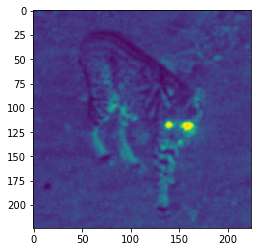

In [ ]:
plt.imshow(data[10,:,:,0])
plt.show()

In [ ]:
labels[10]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
seed = 4
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state=seed)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1630, 224, 224, 3) (182, 224, 224, 3)
(1630, 13) (182, 13)


In [ ]:
x_train = img_flip(x_train)
y_train = np.concatenate([y_train, y_train,y_train])
print(x_train.shape, y_train.shape)

(4890, 224, 224, 3) (4890, 13)


In [ ]:
x_train, y_train = randomize_data(x_train, y_train)
print(x_train.shape, y_train.shape)

(4890, 224, 224, 3) (4890, 13)


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications import vgg16
from keras import backend as K

model = vgg16.VGG16(weights='imagenet', include_top=True)

model.input

# model.summary()

# model.layers.pop(0)
model.layers.pop()

# model.summary()
# newInput = Input(shape=(1,224,224))
new_layer = Dense(13, activation='softmax', name='predictions')

inp = model.input
# inp = newInput
out = new_layer(model.layers[-1].output)

model = Model(inp, out)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [ ]:
# opt = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
# opt = keras.optimizers.Adam(lr= 1e-6)
opt = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint('507_1.h5',monitor='val_acc', verbose=1, save_best_only=True)

trained_model = model.fit(x_train, y_train, 
                           epochs = 10, batch_size = 10,
                           validation_data = (x_test, y_test), 
                           callbacks=[checkpointer], shuffle = False,
                           verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 4890 samples, validate on 182 samples
Epoch 1/10
4890/4890 [==============================] - 125s 25ms/step - loss: 0.8787 - acc: 0.7045 - val_loss: 0.4072 - val_acc: 0.8901

Epoch 00001: val_acc improved from -inf to 0.89011, saving model to 507_1.h5
Epoch 2/10
4890/4890 [==============================] - 120s 25ms/step - loss: 0.3268 - acc: 0.8849 - val_loss: 0.2574 - val_acc: 0.9286

Epoch 00002: val_acc improved from 0.89011 to 0.92857, saving model to 507_1.h5
Epoch 3/10
4890/4890 [==============================] - 120s 25ms/step - loss: 0.1861 - acc: 0.9354 - val_loss: 0.2735 - val_acc: 0.9176

Epoch 00003: val_acc did not improve from 0.92857
Epoch 4/10
4890/4890 [==============================] - 121s 25ms/step - loss: 0.1278 - acc: 0.9597 - val_loss: 0.1899 - val_acc: 0.9286

Epoch 00004: val_acc did not improve from 0.92857
Epoch 5/10
4890/4890 [==============================] - 121s 25ms/step - loss: 0.0833 - acc: 0.9

Confusion matrix, without normalization


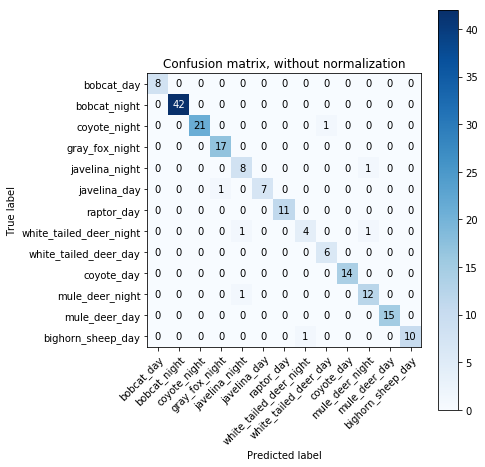

In [ ]:
model_res = load_model('507_1.h5')
# Predict the values from the validation dataset
y_pred = model_res.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
# confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes = classes) 



In [ ]:
misclassified = np.where(y_pred_classes != y_true)
print(misclassified)

(array([ 11,  22,  28,  55, 131, 149, 171]),)


5
[4]


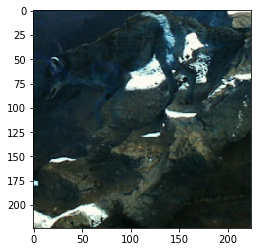

In [ ]:
#for x in np.nditer(misclassified):
b=y_true-y_pred_classes
x=171

print(b[0])

y1=model_res.predict(x_test[x,:,:,:].reshape(1,224,224,3))
y_pred_classe = np.argmax(y1,axis = 1) 
print(y_pred_classe)
plt.imshow(x_test[x,:,:,])
plt.show()



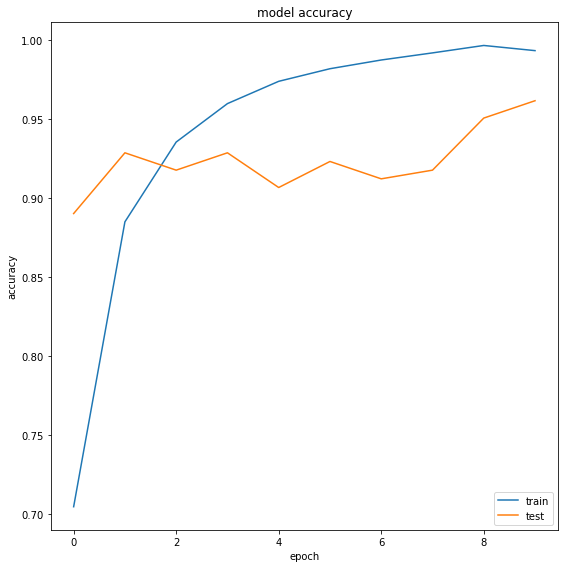

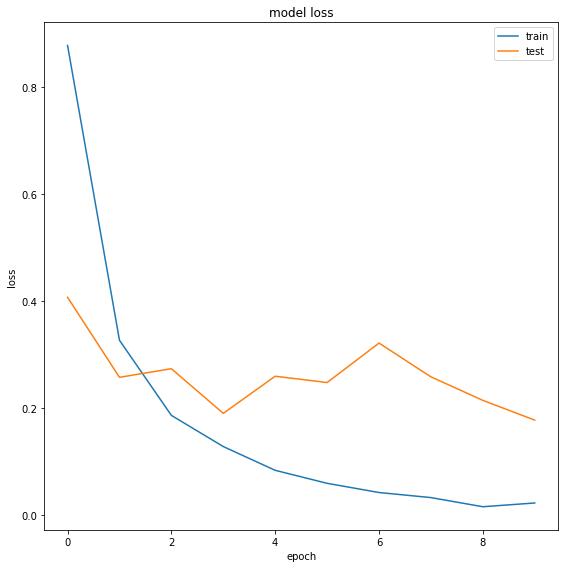

In [ ]:
print("Predicted class-",classes[y_pred_classes[x]])
print("True class-",classes[y_true[x]])
plt.imshow(x_test[x])
plt.show()


import os
# plotting the metrics
plt.figure(figsize=(8,8))
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,8))
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

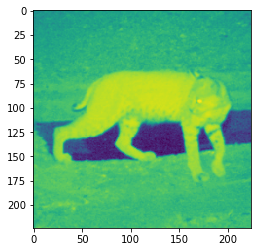

In [ ]:
plt.imshow(x_test[9,:,:,0])
plt.show()

In [ ]:
model.predict(x_test[0,:,:,:].reshape(1,224,224,3))

array([[3.6138095e-05, 5.2185388e-08, 1.1427217e-08, 4.4415526e-07,
        1.9834445e-08, 1.5286454e-03, 7.5784493e-07, 2.7131750e-03,
        5.0554309e-02, 9.4516236e-01, 8.0831518e-07, 2.9775031e-06,
        2.7825106e-07]], dtype=float32)

In [ ]:
y_test[181]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)